In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle

In [53]:
import sys
sys.path.insert(0,'/tigress/changgoo/pyathena-TIGRESS/')

In [54]:
import pyathena.plot_tools.plot_projection as pproj
reload(pproj)

<module 'pyathena.plot_tools.plot_projection' from '/tigress/changgoo/pyathena-TIGRESS/pyathena/plot_tools/plot_projection.pyc'>

In [55]:
from pyathena.plot_tools.plot_projection import *

In [56]:
from pyathena.plot_tools.set_aux import set_aux

In [57]:
from pyathena.preprocessing import doall

In [ ]:
doall(base,problem_id)

preparing metadata for RPS_8pc_ICM3...
moving hst files...
RPS_8pc_ICM3.hst is moved
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.phase1.zprof.nc is created
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.phase2.zprof.nc is created
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.phase3.zprof.nc is created
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.phase4.zprof.nc is created
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.phase5.zprof.nc is created
/tigress/changgoo/RPS_8pc_ICM3/zprof_merged/RPS_8pc_ICM3.whole.zprof.nc is created
Reading a history file:/tigress/changgoo/RPS_8pc_ICM3/hst/RPS_8pc_ICM3.hst.p
/tigress/changgoo/RPS_8pc_ICM3/hst/RPS_8pc_ICM3.hst_cal.p is created
Reading a history file:/tigress/changgoo/RPS_8pc_ICM3/hst/RPS_8pc_ICM3.sn.p
new /tigress/changgoo/RPS_8pc_ICM3/hst/RPS_8pc_ICM3.hst_zp.p is created
slicing and projecting with yt ...
file number: 0 -- Tasks to be done [surf:True phase:False slice:False ]
file number

In [62]:
aux=set_aux()['surface_density']
aux['clim']=(0.01,100)

base='/tigress/changgoo/'
problem_id='RPS_8pc_ICM00'

for itime in range(250,501):
    surfname='{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    scalname='{}{}/surf/{}.{:04d}.scal4.p'.format(base,problem_id,problem_id,itime)
    starname='{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,problem_id,problem_id,itime)


    fig=pproj.plot_projection_icm(surfname,scalname,starname,stars=True,writefile=True,runaway=False,aux=aux)

In [58]:

import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
    for i,surfname in enumerate(surfnames):
        aux=ya.set_aux(os.path.basename(surfname))
        scalfnames=glob.glob(surfname.replace('surf.p','scal?.p'))
        scalfnames.sort()
        starfnames=glob.glob(surfname.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfname.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
        nstar=len(starfnames)
        nscal=len(scalfnames)
       
        if nstar > 0:
            starfname=starfnames[0]
            sp=read_starvtk(starfname)
        
        frb=pickle.load(open(surfname,'rb'))
        if nscal > 0:
            icm=pickle.load(open(scalfnames[iscal],'rb'))
            if icm[axis]['data'].max() > (icm_max*1.1):
                print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

        if 'time' in frb:
            tMyr=frb['time']
        else:
            time,sp=read_starvtk(starfname,time_out=True)
            tMyr=time*Myr
 
        if setup:
            extent=np.array(frb[axis]['bounds'])/1.e3
            x0=extent[0]
            y0=extent[2]
            Lx=extent[1]-extent[0]
            Lz=extent[3]-extent[2]
  
            if axis == 'z': ix=6
            else: ix=3
            iz=ix*Lz/Lx

            cism=plt.cm.bone_r
            cicm=plt.cm.Reds
            cicm._init()
            x=np.arange(cicm.N)
            alphas=0.4*(np.tanh((x-100)/50.)+1)
            #alphas = np.linspace(0.5, 0.5, cicm.N)
            cicm._lut[:-3,-1] = alphas
            cicm._lut[-3,-1] = alphas.min()
            cicm._lut[-2,-1] = alphas.max()
  
            clim=aux['surface_density']['clim']
            cmin=clim[0]
            cmax=clim[1]
            if axis!='z': clim=(cmin*0.01,cmax)
            clim_icm=(0.0,0.5)
            norm_icm=Normalize()

            fig=plt.figure(0,figsize=(ix*nsurf+0.5,iz))
            width_list=[1]*nsurf+[0.1]
            gs = gridspec.GridSpec(3,nsurf+1,width_ratios=width_list,wspace=0.0)
            setup=False

        ax1=plt.subplot(gs[:,i])
        im1=ax1.imshow(frb[axis]['data'],norm=LogNorm(),origin='lower')
        im1.set_extent(extent)
        im1.set_cmap(cism)
        im1.set_clim(clim)

        if nscal > 0:
            icm[axis]['data'] /= icm_max
            im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower')
            im11.set_extent(extent)
            im11.set_cmap(cicm)
            im11.set_clim(clim_icm)

        if nstar > 0: 
            scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor)

        if i==0:
            ax1.set_title('t=%3dMyr' % tMyr,**(texteffect(30)))
        else:
            ax1.set_title('%3dMyr' % tMyr,**(texteffect(30)))

    axes=fig.axes[:nsurf]
    ax1=axes[-1]
    cax=plt.subplot(gs[0,nsurf])
    cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
    cbar.set_label(aux['surface_density']['label'])

    cax=plt.subplot(gs[1,nsurf])
    cbar = fig.colorbar(im11,cax=cax,orientation='vertical')
    cbar.set_label(r'$C_{\rm ICM}$')

    if nstar > 0:
        cax=plt.subplot(gs[2,nsurf])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
             cmap=plt.cm.cool_r, norm=Normalize(vmin=0,vmax=40), 
             orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$')

        s1=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e3)/norm_factor,color='k',
        alpha=.8,label=r'$10^3 M_\odot$')
        s2=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e4)/norm_factor,color='k',
        alpha=.8,label=r'$10^4 M_\odot$')
        s3=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e5)/norm_factor,
        color='k',alpha=.8,label=r'$10^5 M_\odot$')

        starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
        if axis=='z':
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='upper left',ncol=3,bbox_to_anchor=(0.0, 1.15),
                            fontsize='medium',frameon=True)
        else:
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='lower right',fontsize='medium',frameon=True)


    plt.setp(axes,'xlim',(x0,x0+Lx))
    plt.setp(axes,'ylim',(y0,y0+Lz))

    ax1=axes[0]
    if axis=='z':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
    elif axis=='y':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        #plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax1.set_ylabel('z [kpc]')


    plt.setp([ax.get_yticklabels() for ax in axes[1:]],visible=False)
    plt.setp([ax.get_xticklabels() for ax in axes[1:]],visible=False)

    if pngfname is not None:
        plt.savefig(pngfname,bbox_inches='tight',num=0,dpi=150)
        plt.close()
    else:
        return fig


In [60]:
aux=pa.set_aux()

NameError: name 'pa' is not defined

In [ ]:
aux['surface_density']

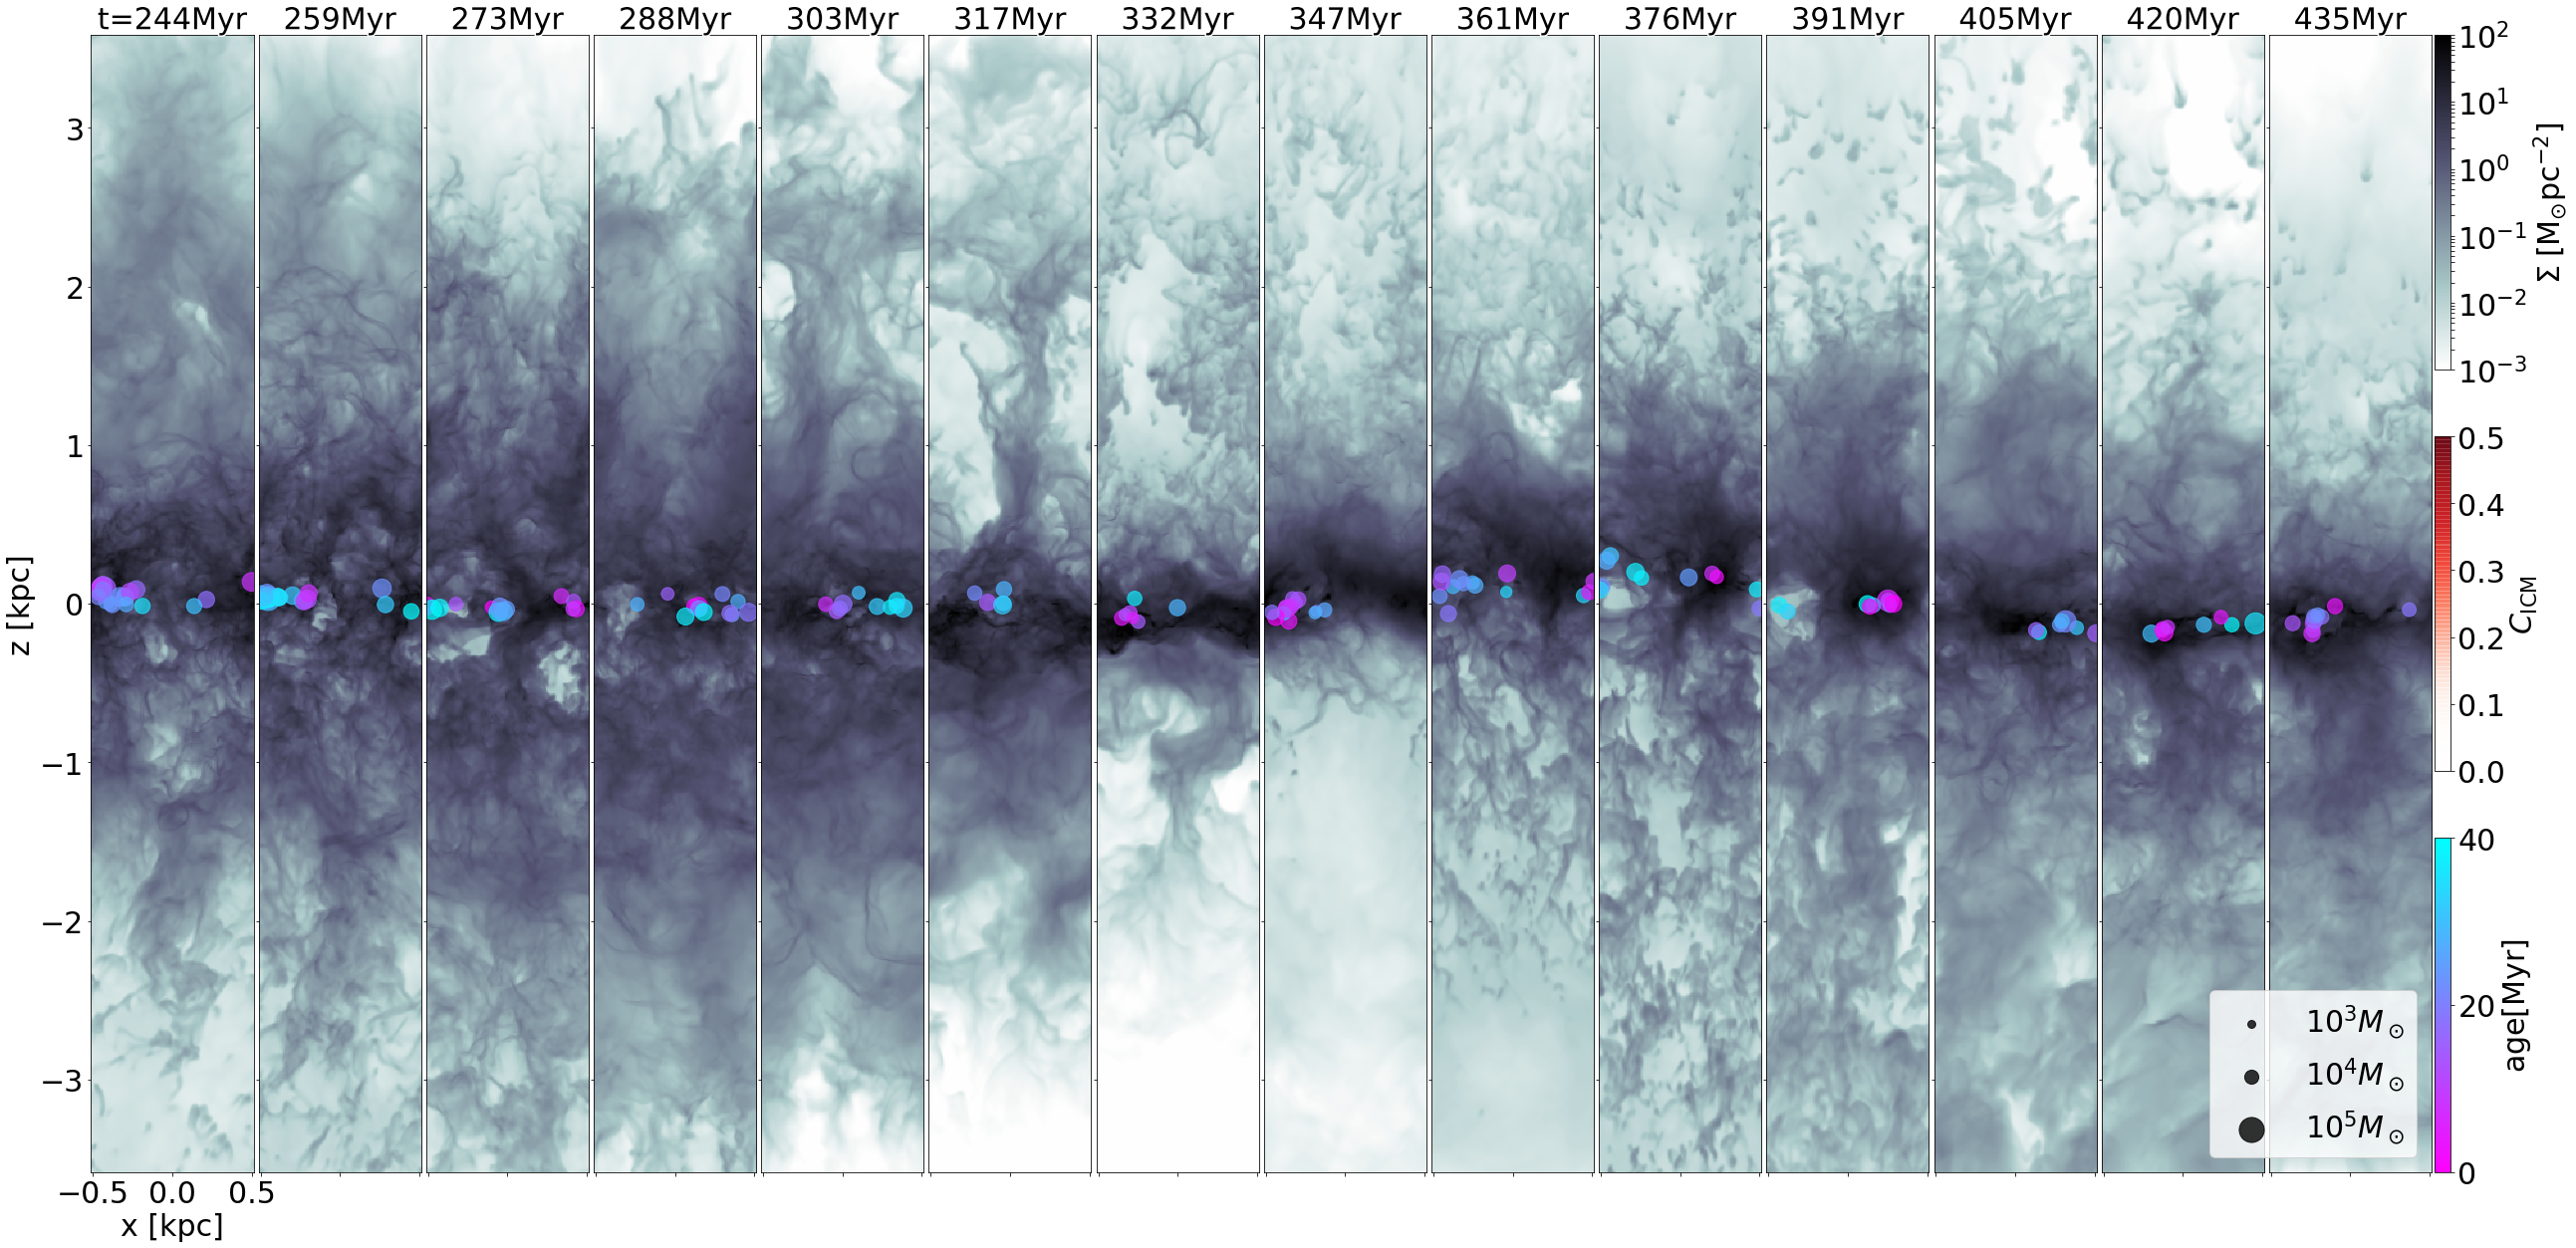

In [89]:
base='/tigress/changgoo/'
problem_id='R8_8pc_metal'

surfnames=[]
for itime in range(250,450,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=-1,norm_factor=0.5)

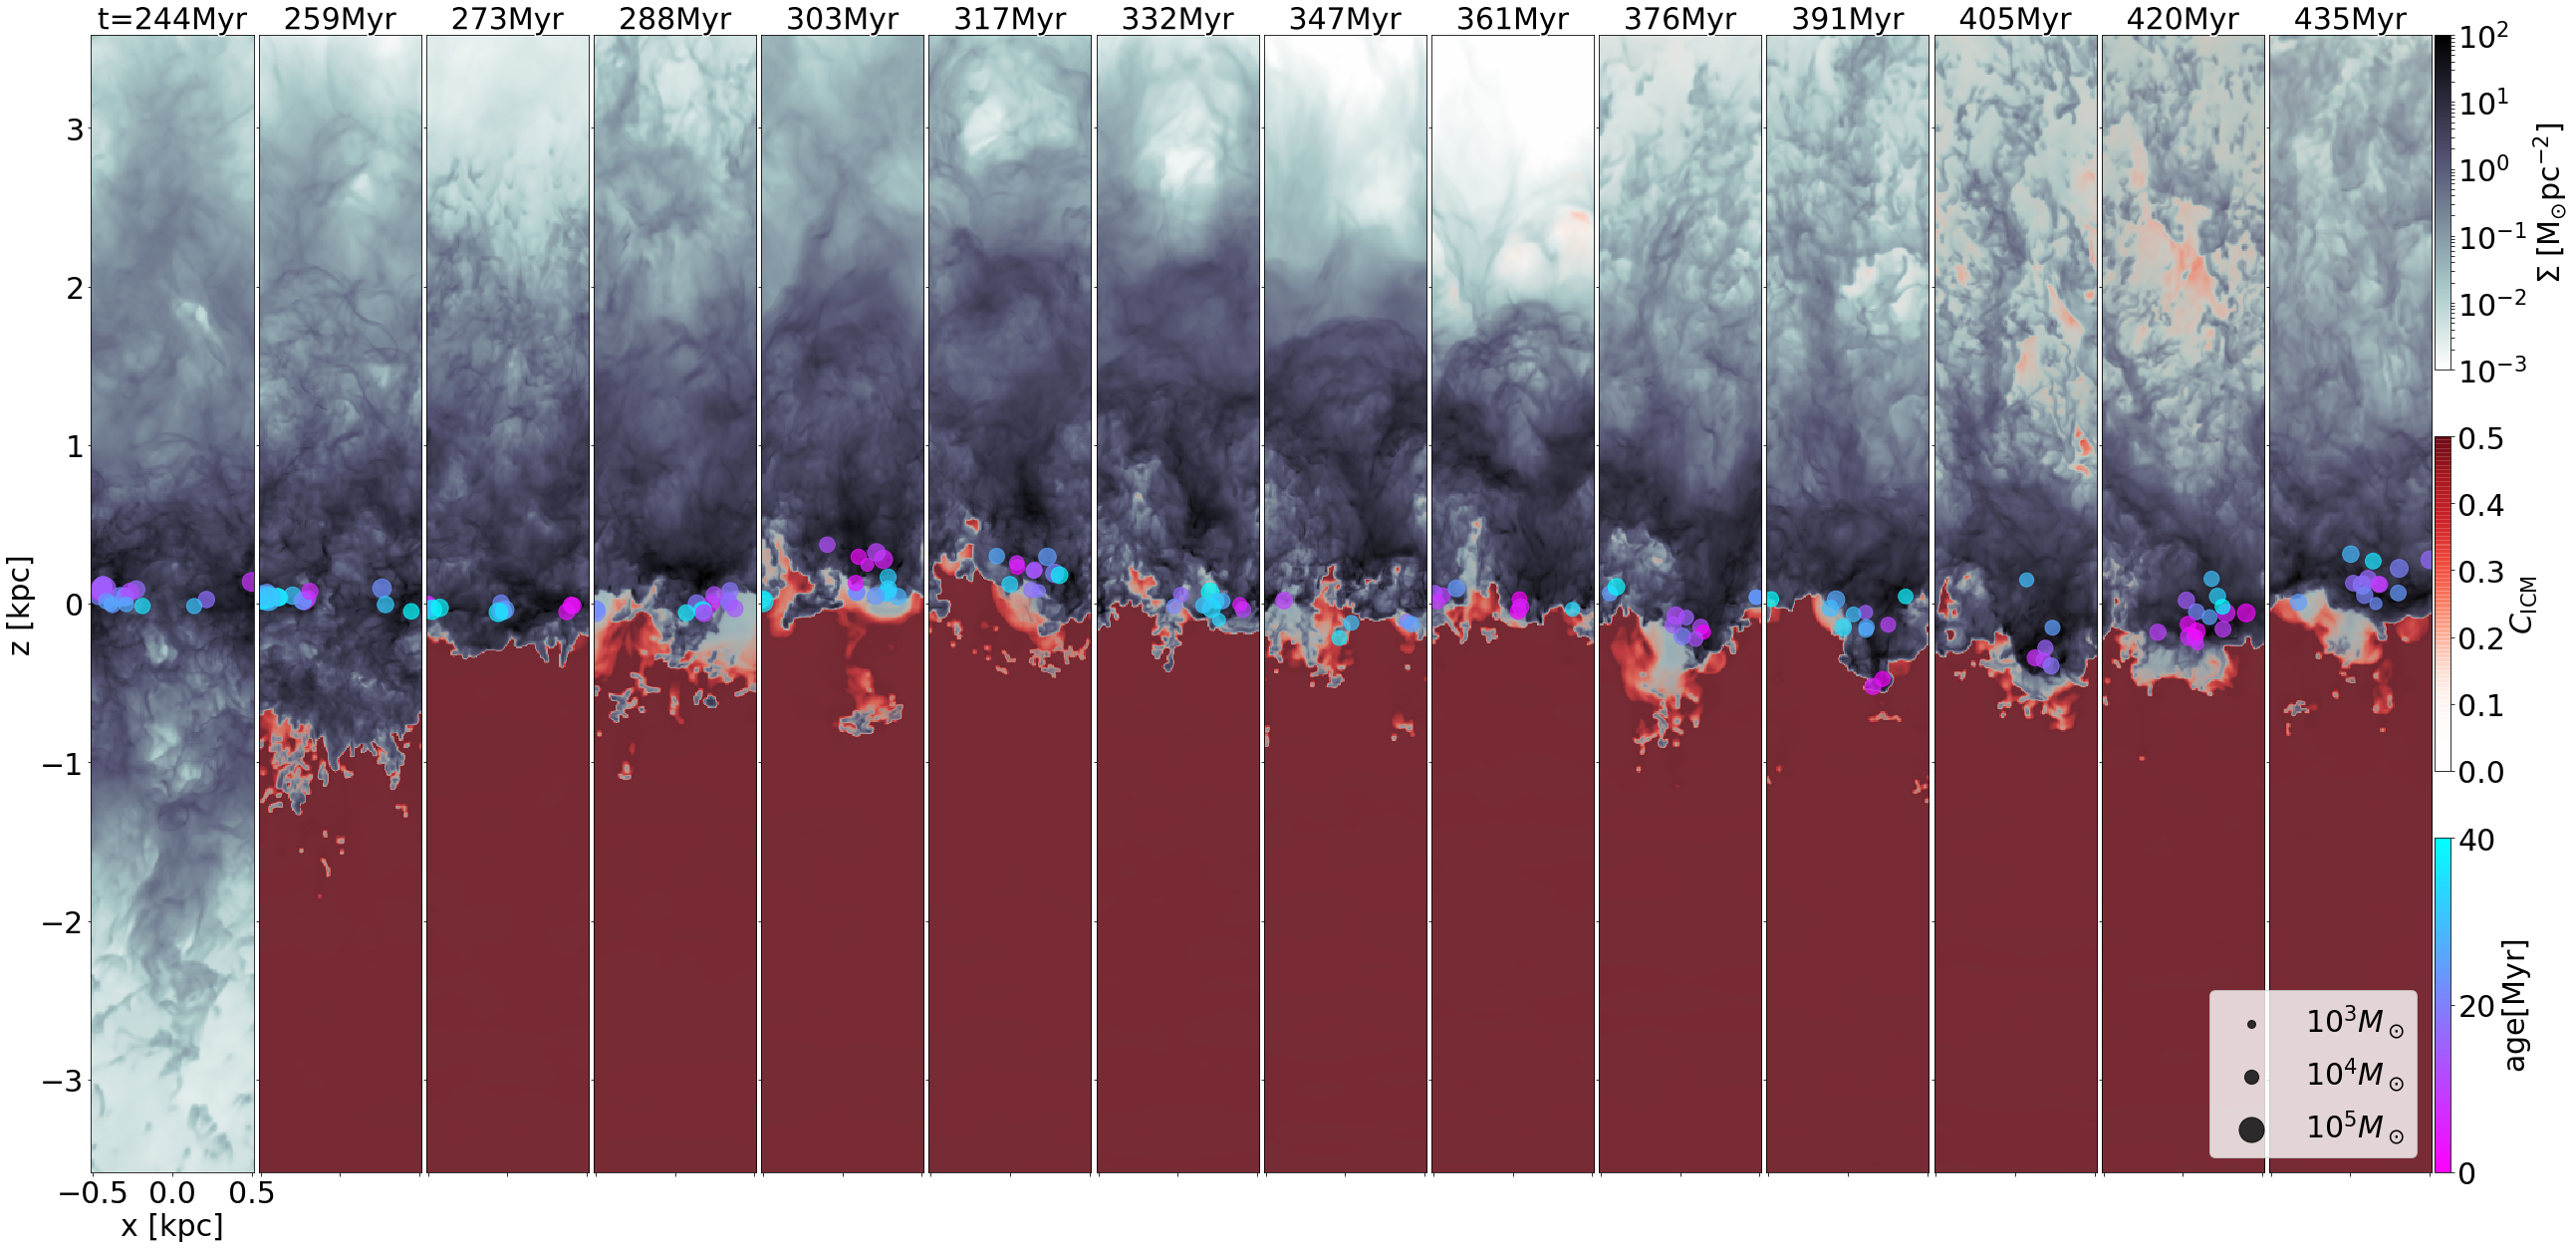

In [90]:
base='/tigress/changgoo/'
problem_id='RPS_8pc_ICM1'

surfnames=[]
for itime in range(250,450,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.5)

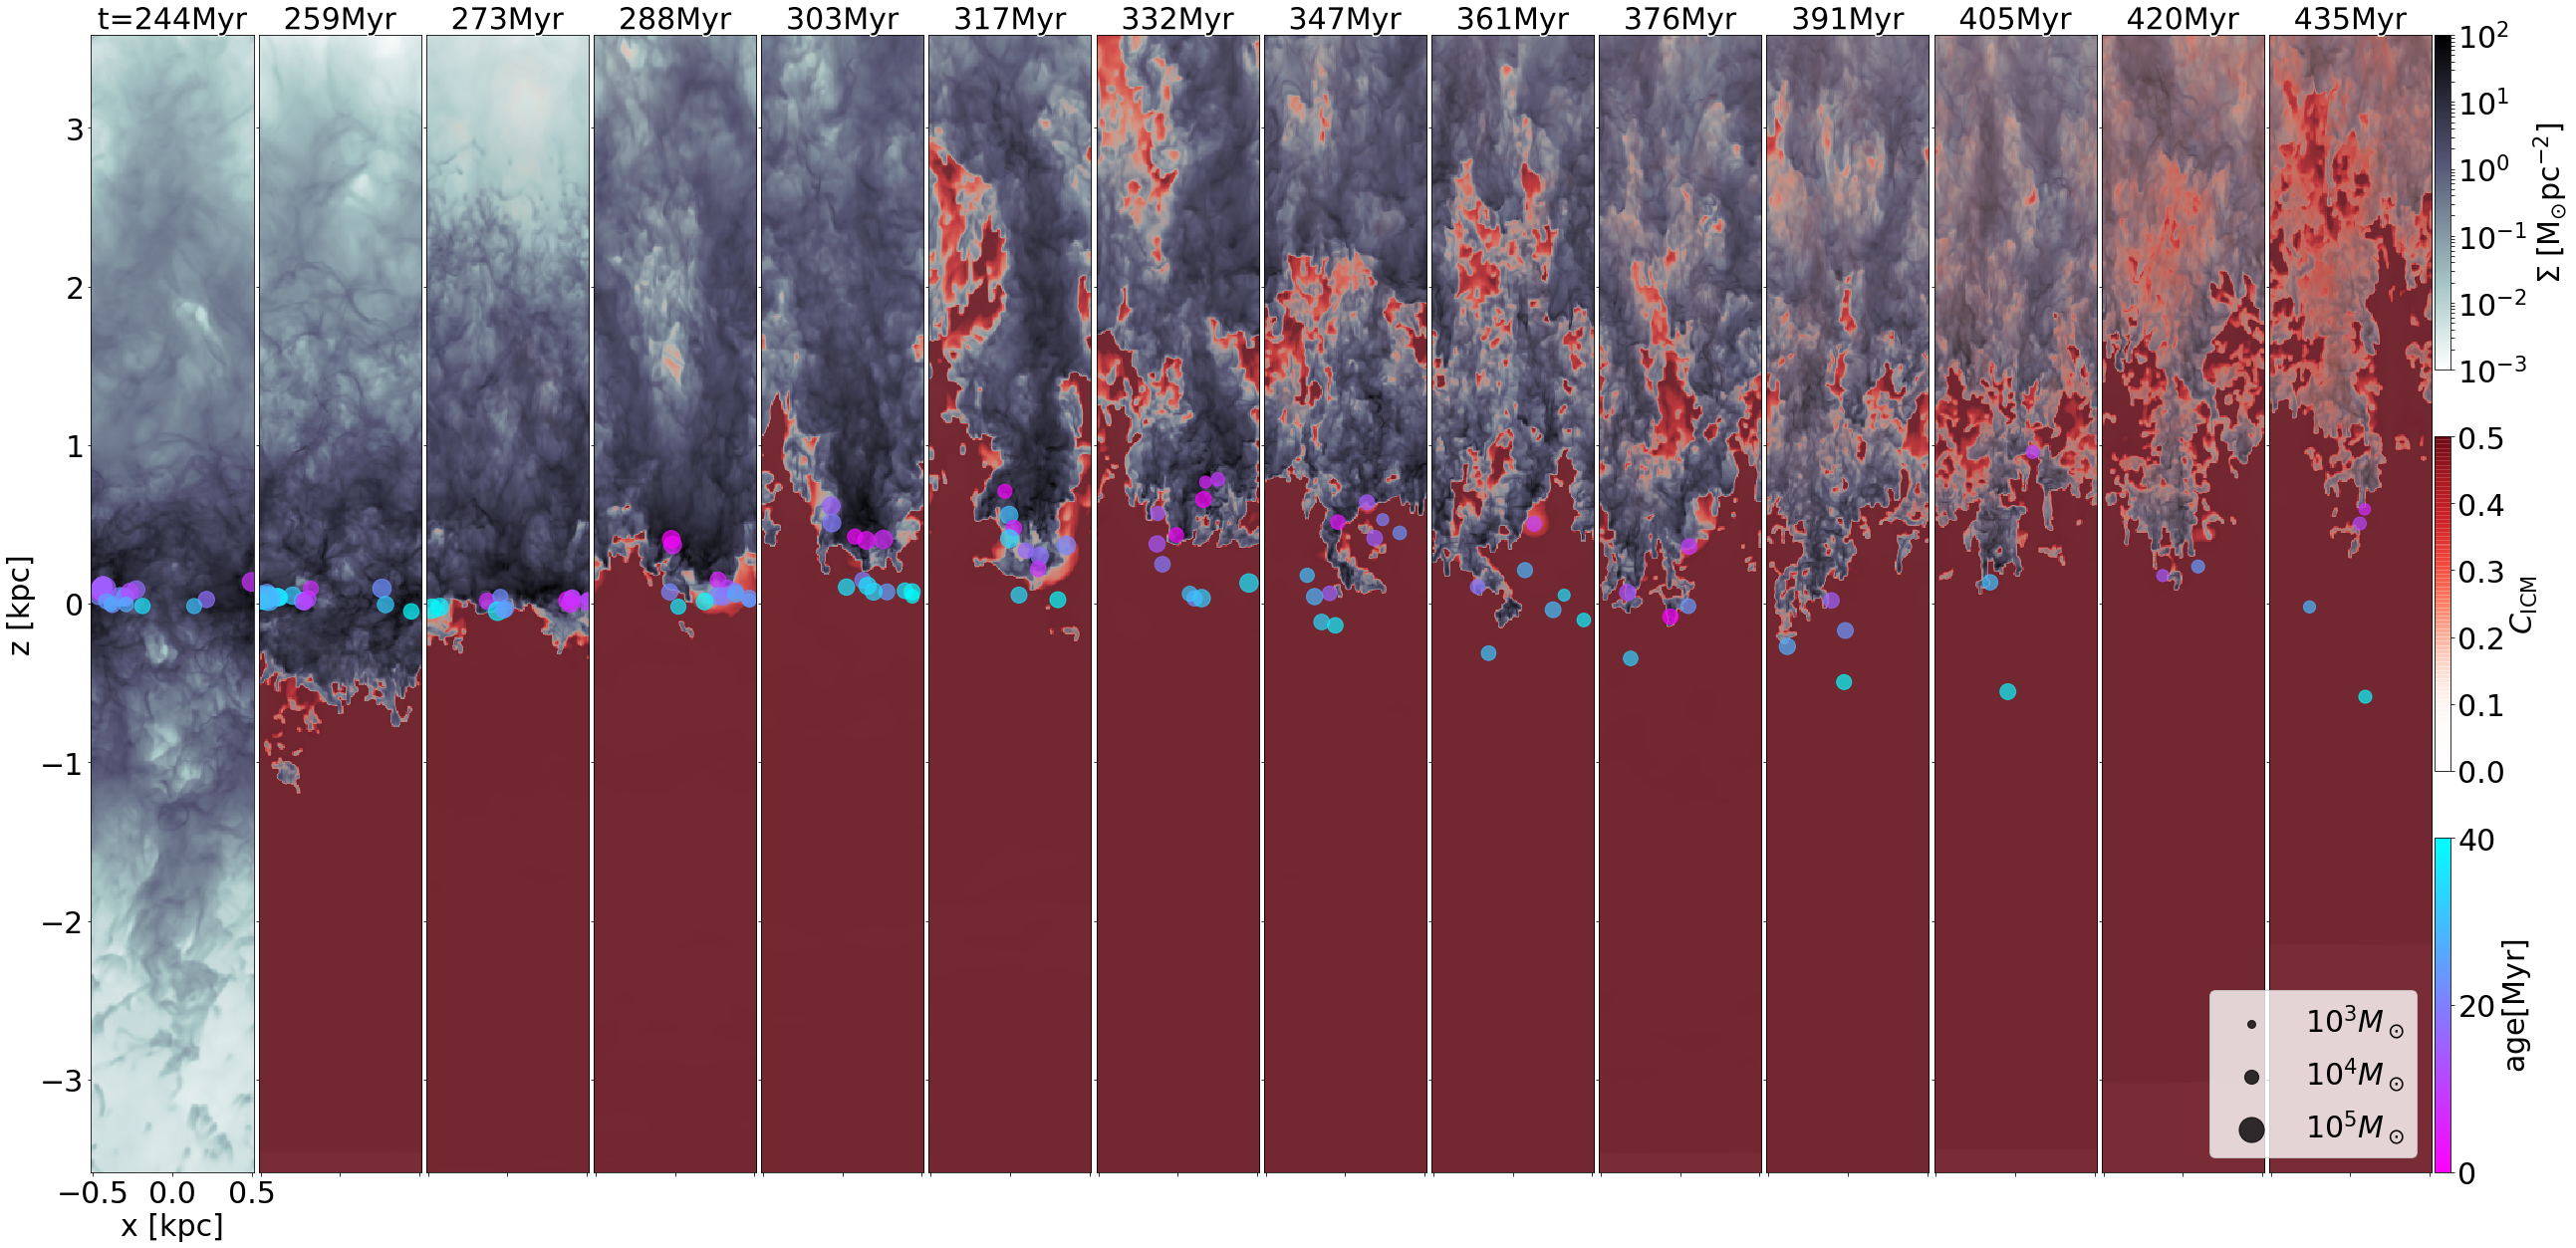

In [91]:
base='/tigress/changgoo/'
problem_id='RPS_8pc_ICM2'

surfnames=[]
for itime in range(250,450,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.5)

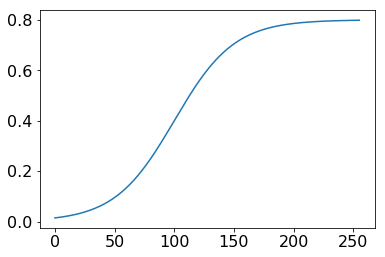

In [58]:
x=np.arange(256)
alphas=0.4*(np.tanh((x-100)/50.)+1)
plt.plot(alphas)